### Overpass

In [5]:
import folium
import requests

#### Functions

In [2]:
def get_overpass_data(query):
    # Define the Overpass API URL
    overpass_url = "https://lz4.overpass-api.de/api/interpreter"

    # Define the parameters for the GET request
    params = {"data": query}

    # Send a GET request to the Overpass API with the query
    response = requests.get(overpass_url, params=params)

    # Get the data from the response
    data = response.json()

    return data

Extract the relevant data

In [8]:
def plot_entities_on_map(data, lat_key="lat", lon_key="lon", name_key="tags", name_subkey="name"):
    # Filter out entities that don't have latitude or longitude
    valid_entities = [entity for entity in data if lat_key in entity and lon_key in entity]

    # If there are no valid entities, return None
    if not valid_entities:
        print("No valid entities with latitude and longitude found.")
        return None

    # Calculate the average latitude and longitude
    avg_lat = sum(entity[lat_key] for entity in valid_entities) / len(valid_entities)
    avg_lon = sum(entity[lon_key] for entity in valid_entities) / len(valid_entities)

    # Create a map centered at the average location
    entity_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

    # Add entities to the map
    for entity in valid_entities:
        lat = entity[lat_key]
        lon = entity[lon_key]
        # Get the name or use a default label if the name is missing
        name = entity.get(name_key, {}).get(name_subkey, "Unnamed location")

        # Create a marker for each entity
        folium.Marker(
            location=[lat, lon],
            popup=name,
        ).add_to(entity_map)

    # Return the folium map object
    return entity_map

Map to plot the data points

#### Pull the data for bus stops in Cuxhaven

In [3]:
# Define the query to retrieve ways within the bounding box
query = f"""
[out:json];
area[name="Cuxhaven"]->.searchArea;
(
  node["highway"="bus_stop"](area.searchArea);
  way["highway"="bus_stop"](area.searchArea);
  relation["highway"="bus_stop"](area.searchArea);
);
out body;
>;
out skel qt;
"""

# Get bus stations in Cuxhaven
data = get_overpass_data(query)

# Visualize data structure
data


{'version': 0.6,
 'generator': 'Overpass API 0.7.62.1 084b4234',
 'osm3s': {'timestamp_osm_base': '2024-10-07T08:07:00Z',
  'timestamp_areas_base': '2024-10-07T03:46:30Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 14789085,
   'lat': 53.8846199,
   'lon': 8.6615788,
   'tags': {'bus': 'yes',
    'fixme': 'Position geschätzt.',
    'highway': 'bus_stop',
    'name': 'Döse, Heinrich-Grube-Weg',
    'public_transport': 'stop_position'}},
  {'type': 'node',
   'id': 96993105,
   'lat': 53.8868704,
   'lon': 8.6438164,
   'tags': {'bus': 'yes',
    'highway': 'bus_stop',
    'name': 'Haus der Kurverwaltung',
    'note': 'Exakte Position muss noch festgelegt werden.',
    'public_transport': 'stop_position',
    'usage': 'tourism'}},
  {'type': 'node',
   'id': 254471185,
   'lat': 53.880292,
   'lon': 8.6248632,
   'tags': {'bus': 'yes',
    'highway': 'bus_stop',
    'n

In [9]:
cuxhaven_bus_map = plot_entities_on_map(data["elements"])
cuxhaven_bus_map


#### Create polygons based on city data

https://ai.gopubby.com/obtaining-geospatial-polygons-for-administrative-areas-of-munich-via-the-overpass-api-ac1c039b63a6

https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as geometry
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import linemerge, polygonize, unary_union


In [10]:
overpass_url = "https://lz4.overpass-api.de/api/interpreter"

# Define the query to retrieve administrative areas in Munich
query = """
[out:json][timeout:25];
area["name"="München"]->.searchArea;
(
  relation["admin_level"="10"]["boundary"="administrative"](area.searchArea);
);
out geom;
"""

# Define the parameters for the GET request
params = {"data": query}

# Send a GET request to the Overpass API with the query
response = requests.get(overpass_url, params=params)
data = response.json()


Create the polygons by converting the json to geojson

In [11]:
# Initialize empty lists to store polygons and names
polygons = []
names = []

# Iterate through elements in the 'data' dictionary
for element in data["elements"]:
    # Check if the element is of type 'relation'
    if element.get("type") == "relation":
        # Initialize an empty list to store LineStrings
        lss = []  # Convert ways to LineStrings
        # Iterate through members of the element
        for member in element["members"]:
            if member["type"] == "way":
                ls_coords = []  # Reset the LineString coordinate list
                nodes = member["geometry"]

                # Iterate through nodes and extract lon and lat
                for point in nodes:
                    lon = point["lon"]
                    lat = point["lat"]
                    ls_coords.append((lon, lat))  # Append coordinate tuple

                # Create a LineString from the coordinates and add it to the list
                lss.append(geometry.LineString(ls_coords))

        # Merge the LineStrings into one
        merged = linemerge([*lss])

        # Convert the merged LineStrings into a MultiLineString
        borders = unary_union(merged)

        # Polygonize the MultiLineString to create polygons
        polygon = list(polygonize(borders))

        # Append the resulting polygon and the name from tags to respective lists
        polygons.append(polygon)
        names.append(element["tags"]["name"])


Convert the data to geodataframe

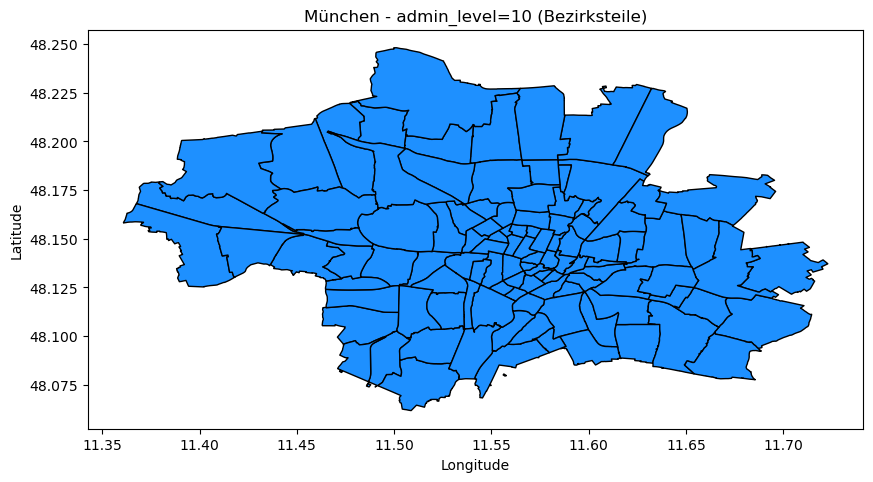

In [14]:
# Create a list of MultiPolygons
multipolygons = [MultiPolygon(polygon) for polygon in polygons]

# Create a GeoDataFrame
geo_data = {"Name": names, "geometry": multipolygons}
df = gpd.GeoDataFrame(geo_data)

# Save the GeoDataFrame as a JSON file
df.to_file("neighbourhoods_munich.json", driver="GeoJSON")

# Create a plot
ax = df.plot(
    figsize=(10, 10),  # Set the figure size (width, height)
    color="dodgerblue",  # Set the color of polygons
    edgecolor="black",  # Set the color of polygon edges
    linewidth=1.0,  # Set the width of polygon edges
    alpha=1.0,  # Set the transparency level (0.0 to 1.0)
)

# Add a title
ax.set_title("München - admin_level=10 (Bezirksteile)")

# Add labels, legend, etc. as needed
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()
